# photometry preprocessing 

This notebook contains allows exploration of different preprocessing options for photometry data. There are various different ways to preprocess this kind of data, so the idea behind this notebook is to act as an easy-to-use resource for trying various approaches out and visualising the results.

The contents of this notebook are heavily, heavily inspired by Thomas Akam's code [here](https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb) - in multiple cases lines of code are directly lifted - although there are some substantial changes/additions to the various steps too. Discussions with Marta Blanco Pozo were very helpful for figuring out how to fit a double exponential, and Luke Coddington was helpful with multiple aspects - explaining his approach (which is almost entirely adopted here), useful discussions, sanity checking, and answering stupid questions. However, if you come across any errors or have any questions please message me at grimal@janelia.hhmi.org.

The main steps for the preprocessing as currently described are as follows: 
1. Lowpass filtering
2. Baseline fit of the signal (F)
3. Highpass filtering
4. Movement correction through linear fit + subtraction from control channel (delta F)
5. Bleaching correction by dividing F by delta F

The data used in this notebook were recorded from the NACc core of a mouse during a freely moving reward-based task. [pyPhotometry](https://pyphotometry.readthedocs.io/en/latest/) acquisition hardware and software was used in two colour time division mode, with GCaMP8m as the calcium indicator and tdTomato as movement control. Here we're using Thomas' import_photometry module to import the uploaded .ppd photometry data file. This will generate a dictionary called 'data' which has keys relating to all of the features of the data, but in essence the below approach works with any set of two lists of data with one containing the sensor values and one containing the control values.  

---

Start by importing python modules needed and setting up figure parameters.

In [5]:
import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

Import the pyPhotometry data import module.

In [8]:
from import_photometry import import_ppd

Import the example data file. 

In [9]:
data_folder = 'data'
data_filename = '6PG5_NAc_conc_2021-09-09_145127.ppd'
data = import_ppd(os.path.join(data_folder, data_filename))

Extract the raw GCaMP and TdTomato signals, session time, and sampling rate.

In [16]:
GCaMP_raw = data['analog_1']
tdTom_raw = data['analog_2']
time_seconds = data['time']/1000
sampling_rate = data['sampling_rate']

## raw signals

We can start by visualising the raw data. Important features to note here include the downward drift of the data in both channels (but particularly the GCaMP channel, possibly due to higher light power being used) due to bleaching, and the reduction of absolute signal size during the recording. 

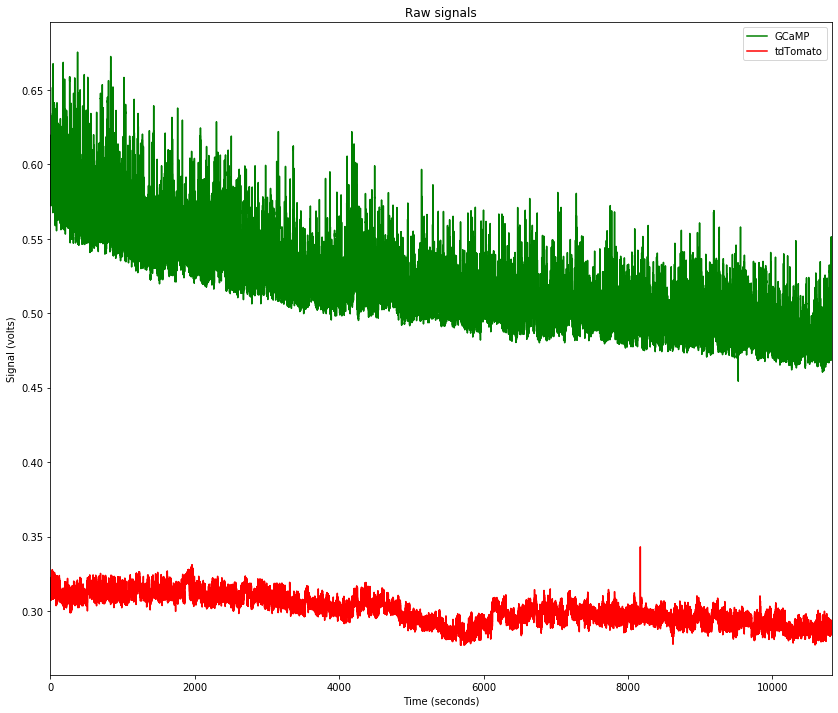

In [17]:
plt.plot(time_seconds, GCaMP_raw, 'g', label='GCaMP')
plt.plot(time_seconds, tdTom_raw, 'r', label='tdTomato')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Raw signals')
plt.legend(loc='best');

## filtering 

There's some evidence of high frequency noise which we can first remove with a simple low pass filter, setting the cut-off at 30Hz (i.e. anything at a higher frequency will be removed). 

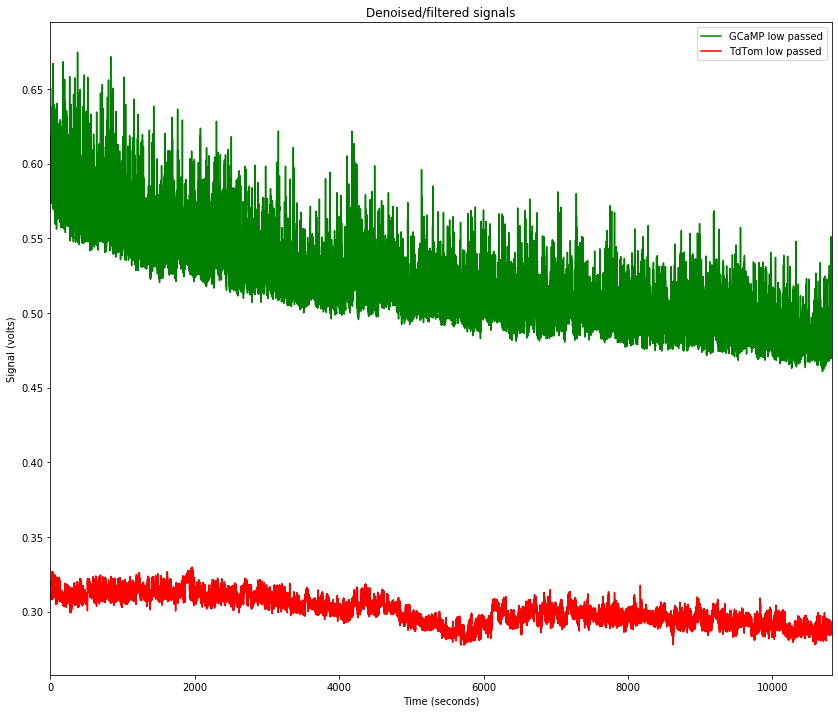

In [20]:
b,a = butter(2, 30,btype='lowpass', fs=data['sampling_rate'])

GCaMP_lowpassed = filtfilt(b,a, GCaMP_raw,padtype='even')
tdTom_lowpassed = filtfilt(b,a, tdTom_raw,padtype='even')

# plot low-passed data
plt.figure()
plt.plot(time_seconds, GCaMP_lowpassed, 'g', label='GCaMP low passed')
plt.plot(time_seconds, tdTom_lowpassed, 'r', label='TdTom low passed') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Low passed signals')
plt.legend(loc='best');    

## baseline fit 

Now we can calculate some sort of baseline for the sensor channel by doing some curve fitting. There are a few different ways to do this but we'll focus on either exponential or polynomial fits to the data. 

### exponential fit

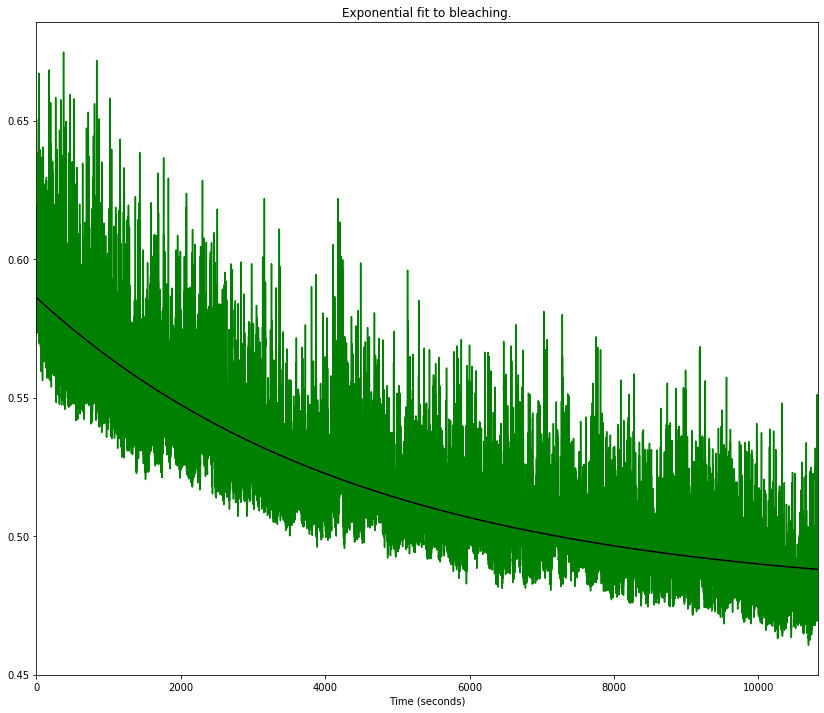

In [24]:
# the exponential curve to be fitted
def exp_func(x, a, b, c):
    return a*np.exp(-b*x) + c

# exponential curve fitting to GCaMP
GCaMP_parms, parm_cov = curve_fit(exp_func, time_seconds, GCaMP_lowpassed, p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
GCaMP_expfit = exp_func(time_seconds, *GCaMP_parms)    

# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_lowpassed, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_expfit,'k', linewidth=1.5) 
plt.title('Exponential fit to bleaching')
plt.xlabel('Time (seconds)');


We can get an idea of how well this fit does by looking at the signal with the fit subtracted. 

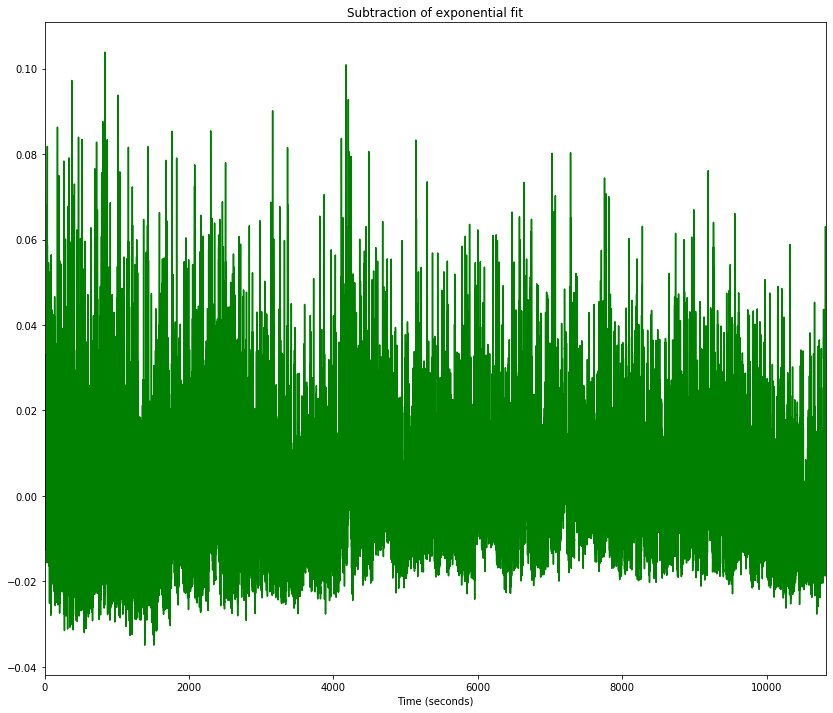

In [25]:
# subtract exponential fit from low passed signal 
GCaMP_baselined_exp = GCaMP_lowpassed - GCaMP_expfit

# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_baselined_exp, 'g', label='GCaMP')
plt.title('Baselining by subtraction of exponential fit')
plt.xlabel('Time (seconds)');



It doesn't do a bad job of 'flattening' the data, but there's still some under-fitting particularly during that initial higher rate of bleaching earlier in the session. This suggests the data might be better fitted by a double exponential.

Double exponential fitting can be tricky to converge - here particularly in terms of finding the right set of upper and lower bounds for the parameters. So the code here tries a few different sets of bounds, and then just runs a linear fit if none of them work. 

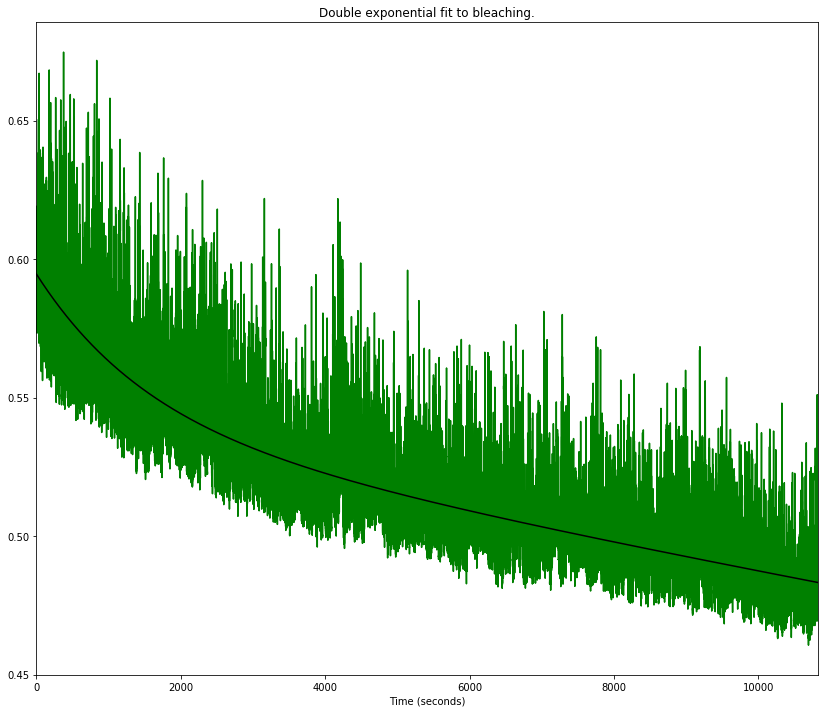

In [30]:
# double exponential curve to be fitted
def dexp_func(x, a, b, c, d): 
    return a*np.exp(b*x) + c *np.exp(d*x)
        
# linear function - for if the double exponential doesn't work out at all...
def linear_func(x, a, b):
    return a + b * x

# double exponential curve fitting to signal
try:
    GCaMP_parms, parm_cov = curve_fit(dexp_func, time_seconds, GCaMP_lowpassed, p0=(1, 1e-6, 1, 1e-6))
    GCaMP_dexpfit = dexp_func(time_seconds, *GCaMP_parms)
except RuntimeError:
    try:
        GCaMP_parms, parm_cov = curve_fit(dexp_func, np.arange(len(GCaMP_lowpassed)), GCaMP_lowpassed, p0=(1, 1e-6, 0, 1e-6))
        GCaMP_dexpfit = dexp_func(time_seconds, *GCaMP_parms)
    except RuntimeError:
        try:
            GCaMP_parms, parm_cov = curve_fit(dexp_func, time_seconds, GCaMP_lowpassed, p0=(-1, 1e-6, 0, 1e-6))
            GCaMP_dexpfit = dexp_func(time_seconds, *GCaMP_parms)
        except RuntimeError:
            GCaMP_parms, parm_cov = curve_fit(linear_func, time_seconds, GCaMP_lowpassed, p0=(1e-6, 0))
            GCaMP_dexpfit = linear_func(time_seconds, *GCaMP_parms)
            print('LINEAR FIT')
            
# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_lowpassed, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_dexpfit,'k', linewidth=1.5) 
plt.title('Double exponential fit to bleaching.')
plt.xlabel('Time (seconds)');

As before, we can subtract the fit from the signal to get a feeling for how well it is linearising the curve.

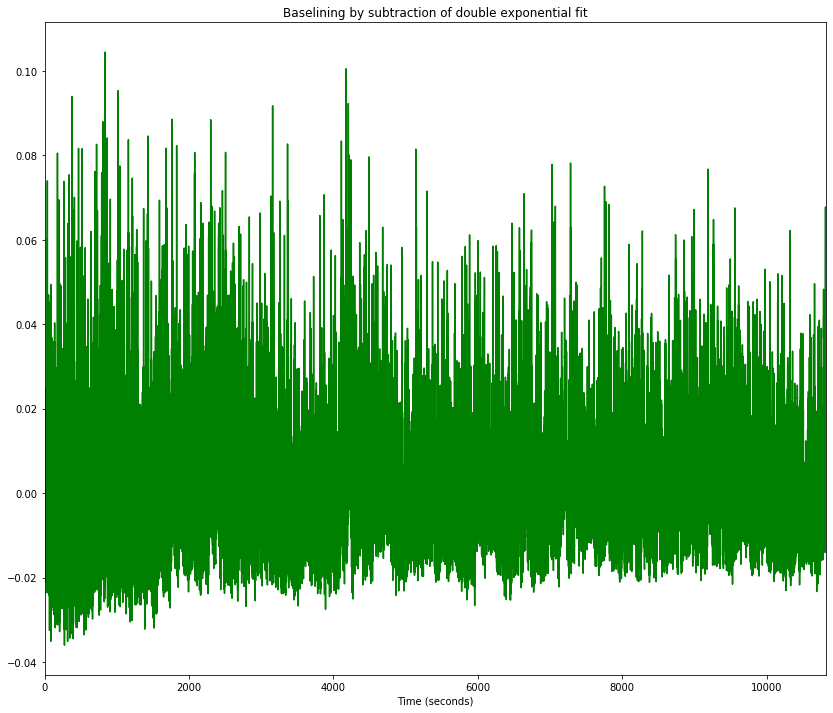

In [32]:
# subtract double exponential fit from lowpassed signal
GCaMP_baselined_dexp = GCaMP_lowpassed - GCaMP_dexpfit    

# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_baselined_dexp, 'g', label='GCaMP')
plt.title('Baselining by subtraction of double exponential fit')
plt.xlabel('Time (seconds)');        

As you can see, it does a slightly better job than a simple exponential (and from my experience this is generally the case). It also doesn't usually result in overfitting. 

### polynomial fit

Another approach is to fit an nth order polynomial which allows for more flexibility in fitting. However that does mean that the key decision here is the order of the polynomial - too low and it'll miss some of the dynamics that need to be accounted for, too high and it'll potentially fit to dynamics in the signal that are 'real', i.e. slower timescale changes in dopamine that are separate from bleaching. Let's start with a 2nd order polynomial. 

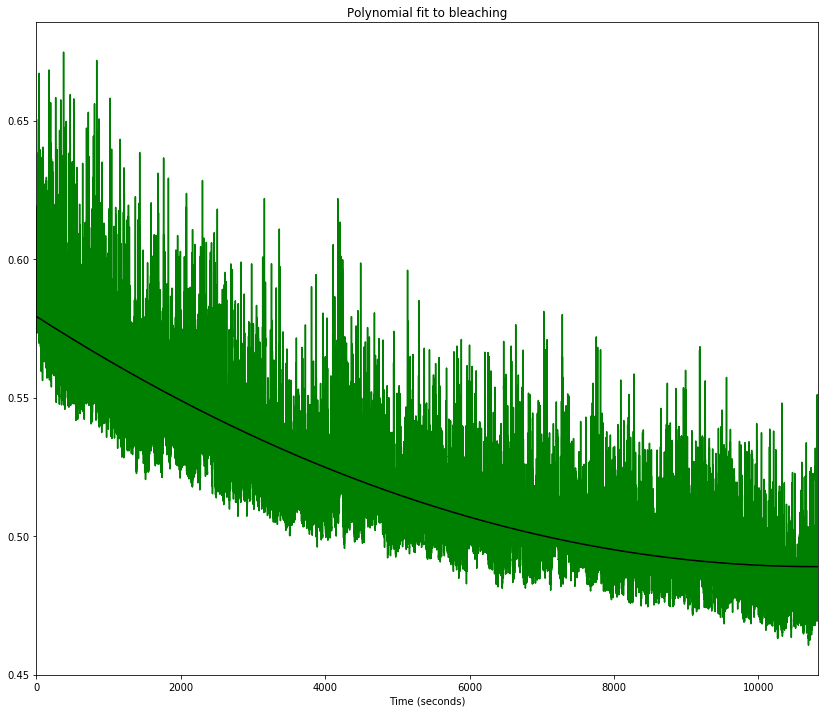

In [34]:
# fit to second order polynomial
coefs_GCaMP = np.polyfit(time_seconds, GCaMP_lowpassed, deg=2)
GCaMP_polyfit = np.polyval(coefs_GCaMP, time_seconds)

# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_lowpassed, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_polyfit,'k', linewidth=1.5) 
plt.title('Polynomial fit to bleaching - second order')
plt.xlabel('Time (seconds)');
            

As with the single exponential, there is some underfitting here - especially at the beginning of the session. Let's increase the polynomial order.

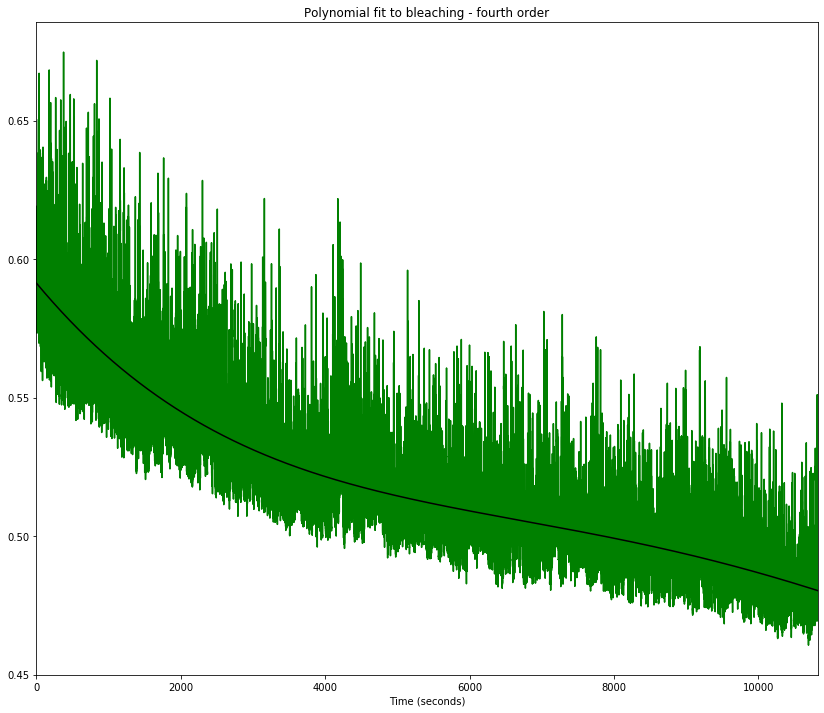

In [35]:
coefs_GCaMP = np.polyfit(time_seconds, GCaMP_lowpassed, deg=4)
GCaMP_polyfit = np.polyval(coefs_GCaMP, time_seconds)

# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_lowpassed, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_polyfit,'k', linewidth=1.5) 
plt.title('Polynomial fit to bleaching - fourth order')
plt.xlabel('Time (seconds)');
        

Now the bleaching dynamics are better captured earlier in the session (though arguably still not as well as the double exponential...) but there's a hint of over fitting later in the session. You can try it out for yourself but the third order polynomial also has a similar fit. This potential overfitting also illustrated by the corrected signal.

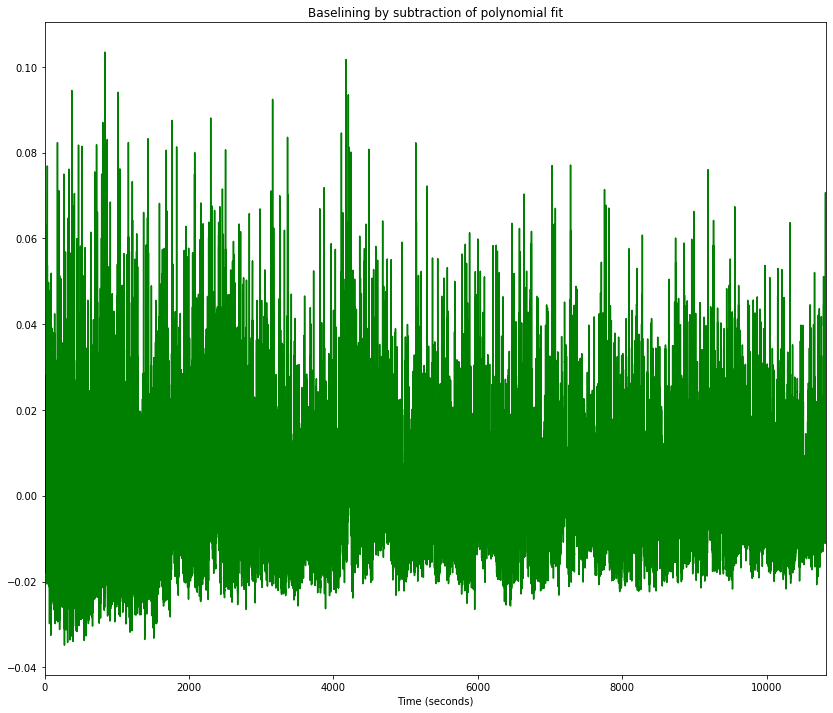

In [36]:
# subtract fourth order polynomial fit from lowpassed signal
GCaMP_baselined_poly = GCaMP_lowpassed - GCaMP_polyfit

# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_baselined_poly, 'g', label='GCaMP')
plt.title('Baselining by subtraction of polynomial fit')
plt.xlabel('Time (seconds)');              
        

Because of this, my preference has recently tended towards using a double exponential. But check what works best for your own data.

## highpass filter 

As both channels will have been subject to bleaching, it is often a good idea before applying movement correction to highpass filter the data - in other words, to remove slower changes that might alter the fit for the movement correction by increasing the correlation between the channels. Here we will use a very low cutoff to maintain as much of the slower dynamics as possible whilst still allowing a fit of the control to the signal.

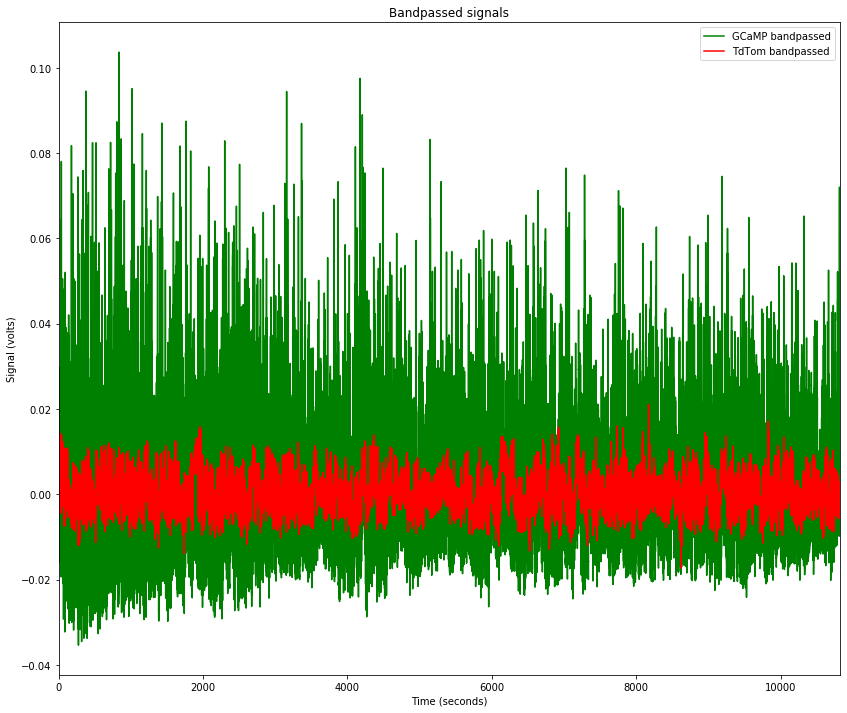

In [39]:
# highpass filter
b,a = butter(2, 0.001,btype='highpass', fs=data['sampling_rate'])

GCaMP_bandpassed = filtfilt(b,a, GCaMP_lowpassed,padtype='even')
tdTom_bandpassed = filtfilt(b,a, tdTom_lowpassed,padtype='even')

# visualise
plt.figure()
plt.plot(time_seconds, GCaMP_bandpassed, 'g', label='GCaMP bandpassed')
plt.plot(time_seconds, tdTom_bandpassed, 'r', label='TdTom bandpassed') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Bandpassed signals')
plt.legend(loc='best');    

## movement correction

Now we can correct for movements picked up by the control channel by finding the best linear fit of the control to the signal and subtracting it. We'll be doing this on the bandpass (lowpass + highpass) filtered data.  

Slope    : 0.521
R-squared: 0.020


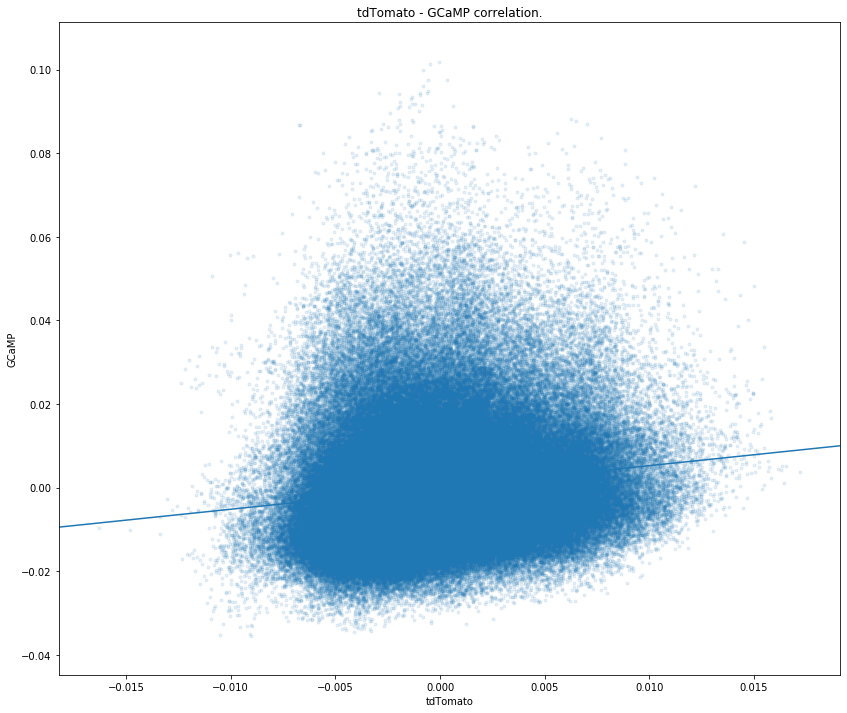

In [46]:
# calculating best linear fit
slope, intercept, r_value, p_value, std_err = linregress(x=tdTom_bandpassed, y=GCaMP_bandpassed)

# visualising correlation between signal and control
plt.figure()
plt.scatter(tdTom_bandpassed[::5], GCaMP_bandpassed[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('tdTomato')
plt.ylabel('GCaMP')
plt.title('tdTomato - GCaMP correlation.')
    
print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))   

Let's visualise what motion correction does to the data across the session, and in a shorter snippet (to make it easier to see the differences).

(0, 60)

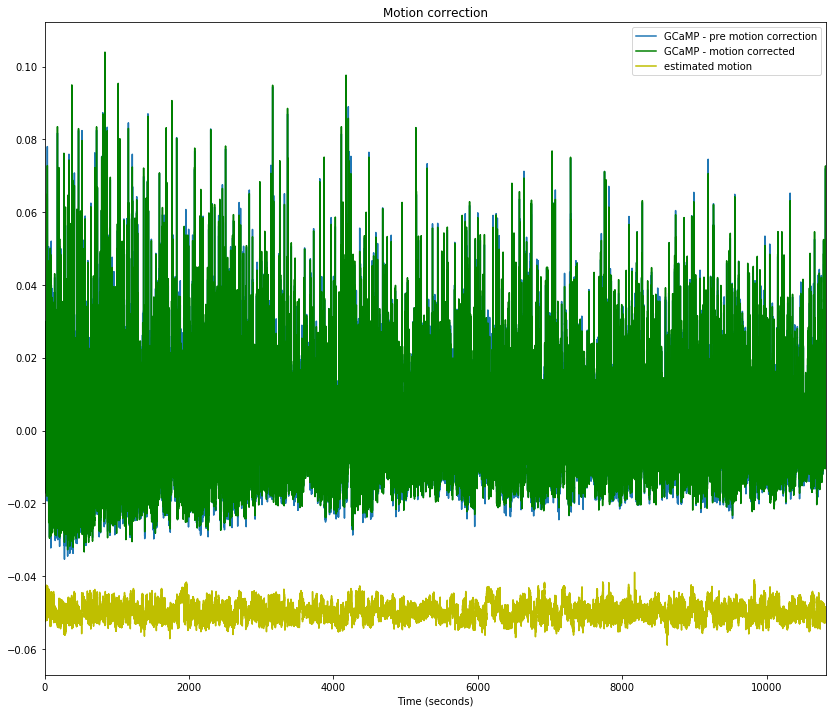

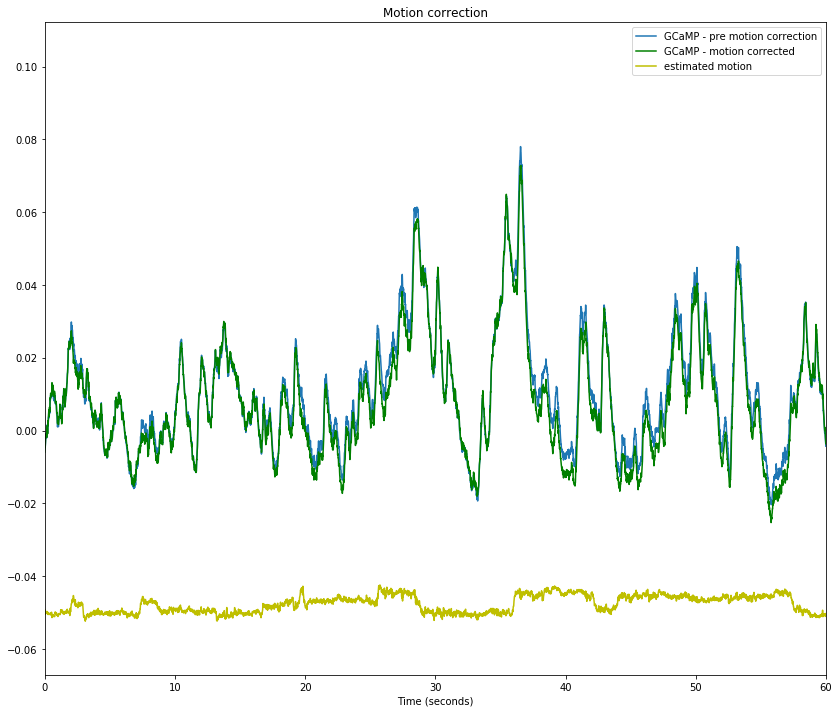

In [47]:
GCaMP_est_motion = intercept + slope * tdTom_bandpassed
GCaMP_corrected = GCaMP_bandpassed - GCaMP_est_motion

plt.figure()
plt.plot(time_seconds, GCaMP_bandpassed, label='GCaMP - pre motion correction')
plt.plot(time_seconds, GCaMP_corrected, 'g', label='GCaMP - motion corrected')
plt.plot(time_seconds, GCaMP_est_motion - 0.05, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction')
plt.legend(loc='best')  


plt.figure()
plt.plot(time_seconds, GCaMP_bandpassed, label='GCaMP - pre motion correction')
plt.plot(time_seconds, GCaMP_corrected, 'g', label='GCaMP - motion corrected')
plt.plot(time_seconds, GCaMP_est_motion - 0.05, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction')
plt.legend(loc='best')  
plt.xlim(0,60)

## df/f

Our movement corrected signal now needs to be scaled to the fit we calculated earlier to account for effects of bleaching. This simply means dividing the corrected signal (delta f) by the fit (f) - in this case we'll use the double exponential. 

Text(0, 0.5, 'df/f (%)')

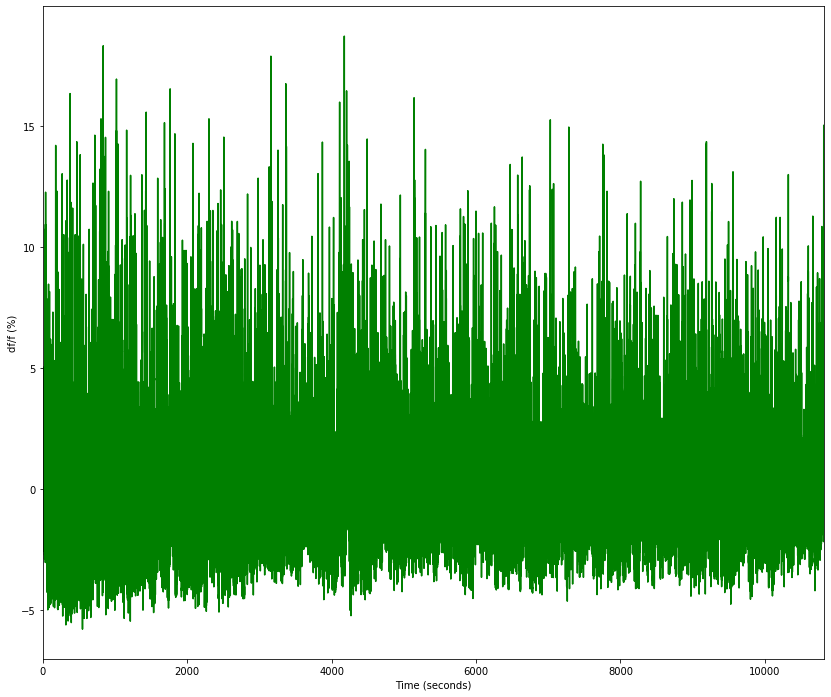

In [49]:
# calculate df/f
df_f = GCaMP_corrected/GCaMP_dexpfit  

# visualise 
plt.figure()
plt.plot(time_seconds,df_f*100, 'g')
plt.xlabel('Time (seconds)')
plt.ylabel('df/f (%)')
plt.title('Delta F/F')


For the sake of comparison let's overlay the data with and without the bleaching correction.

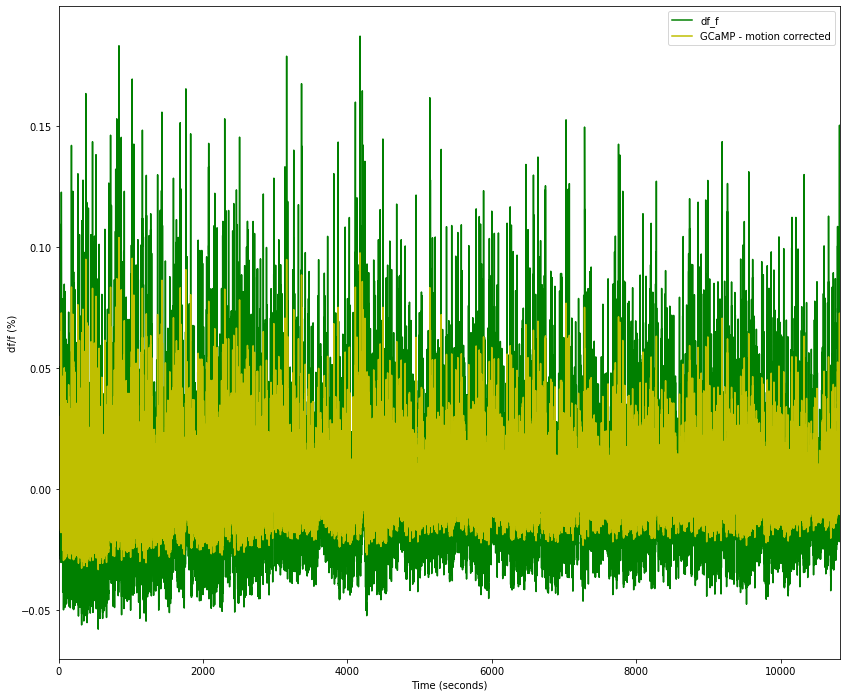

In [56]:
plt.figure()
plt.plot(time_seconds,df_f, 'g',label='df_f')
plt.plot(time_seconds,GCaMP_corrected, 'y', label='GCaMP - motion corrected')
plt.xlabel('Time (seconds)')
plt.ylabel('signal')
plt.legend(loc='best')  
